In [3]:
%matplotlib inline
from rtxlib.rtx_run import setup_database, db
from analysis_lib.one_sample_tests import KolmogorovSmirnov
from analysis_lib.two_sample_tests import Ttest

# index = "rtx10" # cars: 750, smart cars: 150, no pendulum
# index = "rtx11" # cars: 750, dual of 10
# index = "rtx20" # cars: 750, smart cars: 150, pendulum
# index = "rtx30" # cars: 750, smart cars: 400, pendulum
# index = "rtx31" # cars: 750, dual of 30
# index = "rtx40" # cars: 750, smart cars: 750, pendulum
# index = "rtx50"   # cars: 750, smart cars: 750, no pendulum
# index = "rtx1000"   # cars: 1000, smart cars: 1000, no pendulum
index = "rtx1001" # dual of 1000

knob_names = [
    "route_random_sigma",
    "exploration_percentage",
    "max_speed_and_length_factor",
    "average_edge_duration_factor",
    "freshness_update_factor",
    "freshness_cut_off_value",
    "re_route_every_ticks",
]

knob_values = [
    [0, 0.2, 0.4, 0.6, 1, 1.5, 2, 2.5],             # route_random_sigma
    [0, 0.2, 0.4, 0.6],             # exploration_percentage
    [1, 1.5, 2, 2.5],               # max_speed_and_length_factor
    [1, 1.5, 2, 2.5],               # average_edge_duration_factor
    [5, 10, 15, 20],                # freshness_update_factor
    [100, 200, 300, 400, 500, 600], # freshness_cut_off_value
    [10, 20, 30, 40, 50, 60]        # re_route_every_ticks",
]

setup_database(index)
results = db().get_all_data_points()

res = {}
data = {}
knobs = {}

print "~~~~~~~~~"
print index
print "~~~~~~~~~"
for j in range(7): 
    knob_name = knob_names[j]
    print knob_name 
    print "---------"
    for i in knob_values[j]:    
        res = [r for r in results if r[1].get(knob_name)==i]
        data[i] = [r[0] for r in res]
        knobs[i] = [r[1] for r in res]
        print str(i)+"'s: " + str(len(data[i]))
    print "========="

> OEDA configuration: Using elasticsearch database.
~~~~~~~~~
rtx1000
~~~~~~~~~
route_random_sigma
---------
0's: 20100
0.2's: 20100
0.4's: 20100
0.6's: 20100
1's: 20000
1.5's: 20000
2's: 20000
2.5's: 20000
exploration_percentage
---------
0's: 0
0.2's: 0
0.4's: 0
0.6's: 0
max_speed_and_length_factor
---------
1's: 0
1.5's: 0
2's: 0
2.5's: 0
average_edge_duration_factor
---------
1's: 0
1.5's: 0
2's: 0
2.5's: 0
freshness_update_factor
---------
5's: 0
10's: 0
15's: 0
20's: 0
freshness_cut_off_value
---------
100's: 0
200's: 0
300's: 0
400's: 0
500's: 0
600's: 0
re_route_every_ticks
---------
10's: 0
20's: 0
30's: 0
40's: 0
50's: 0
60's: 0


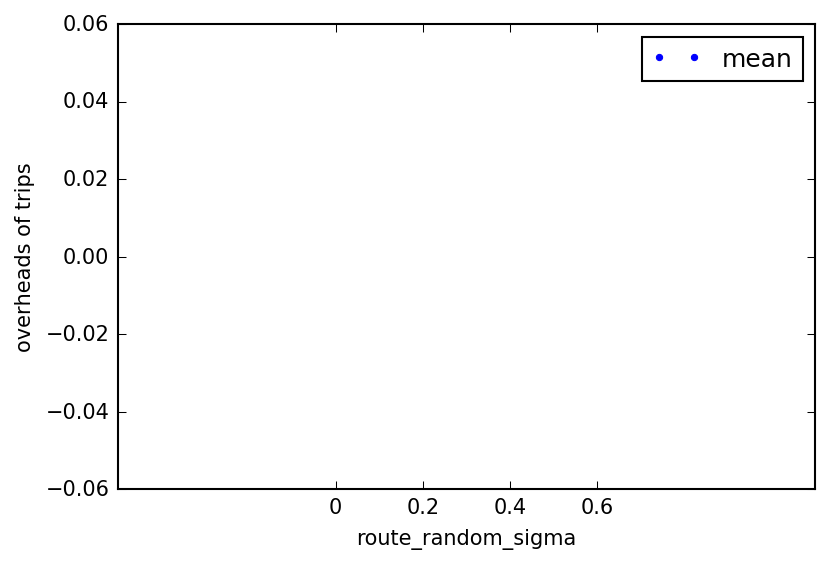

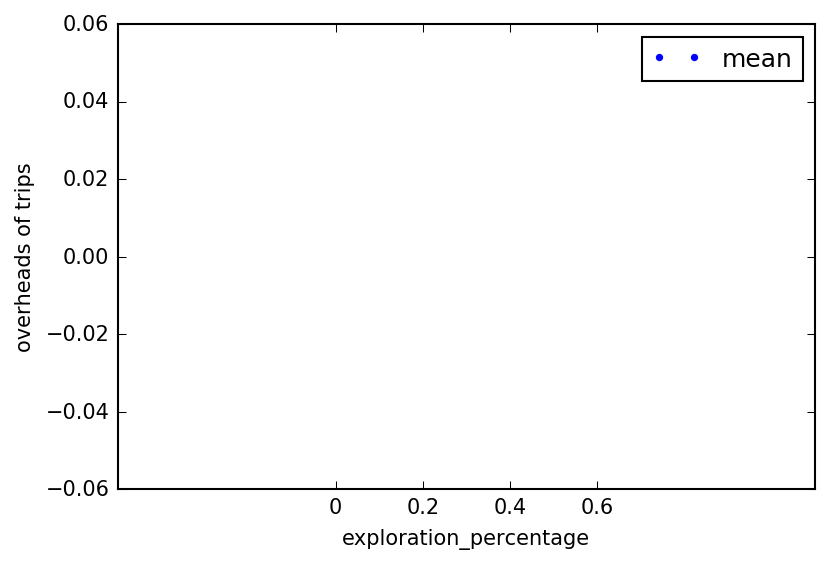

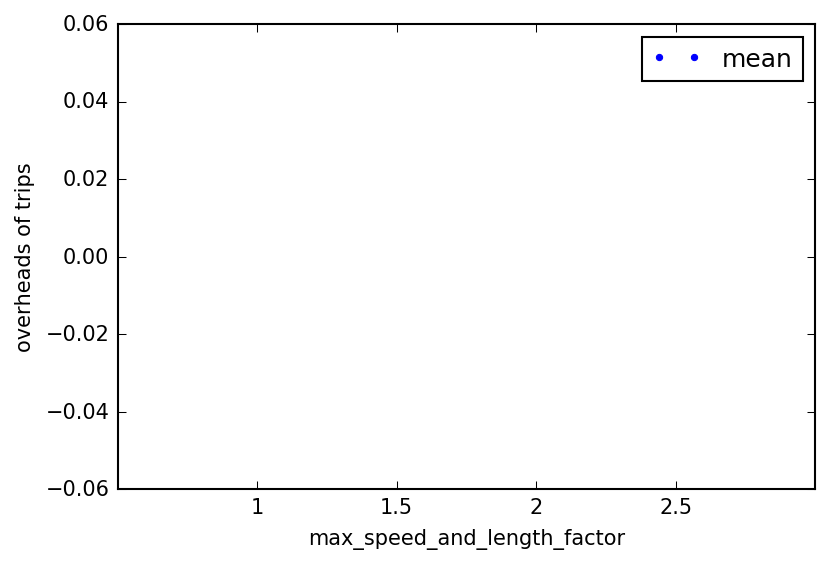

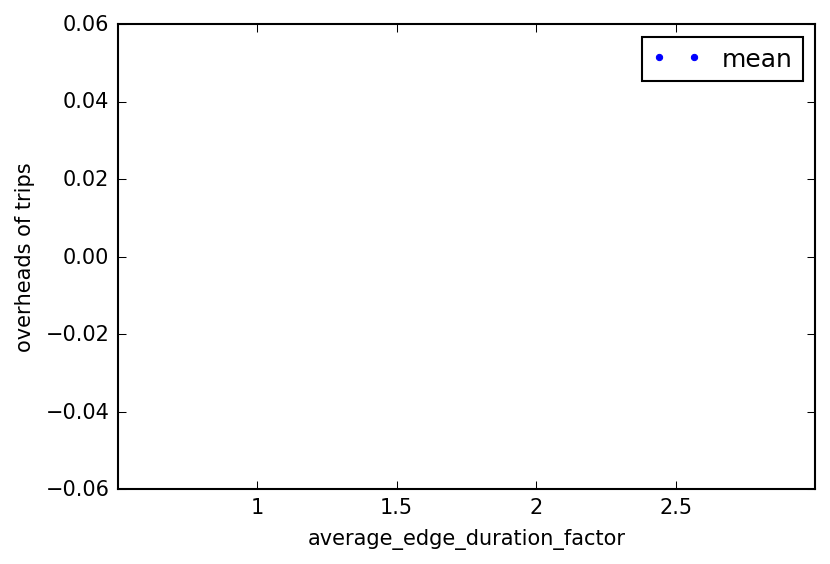

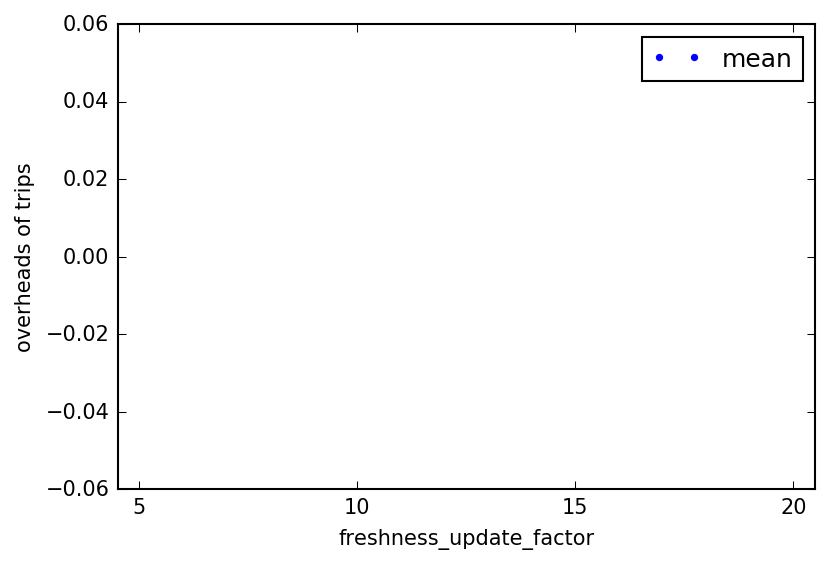

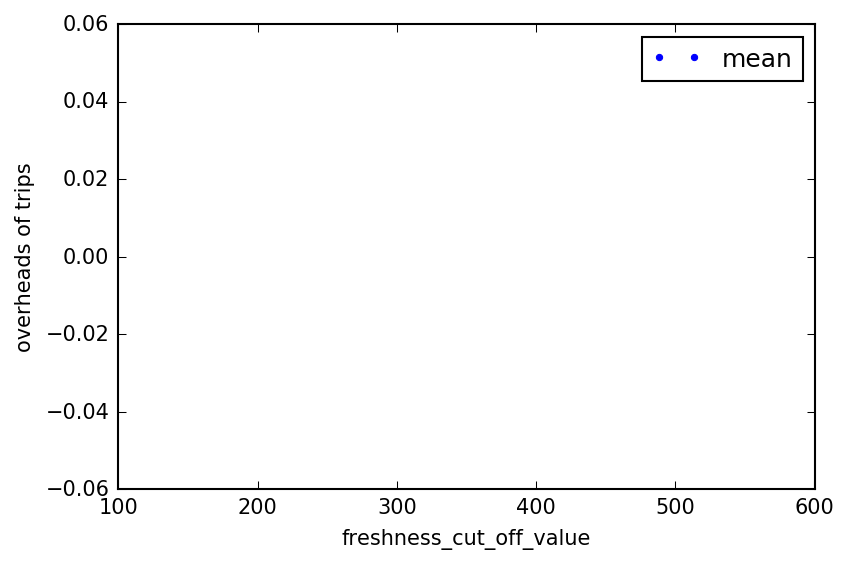

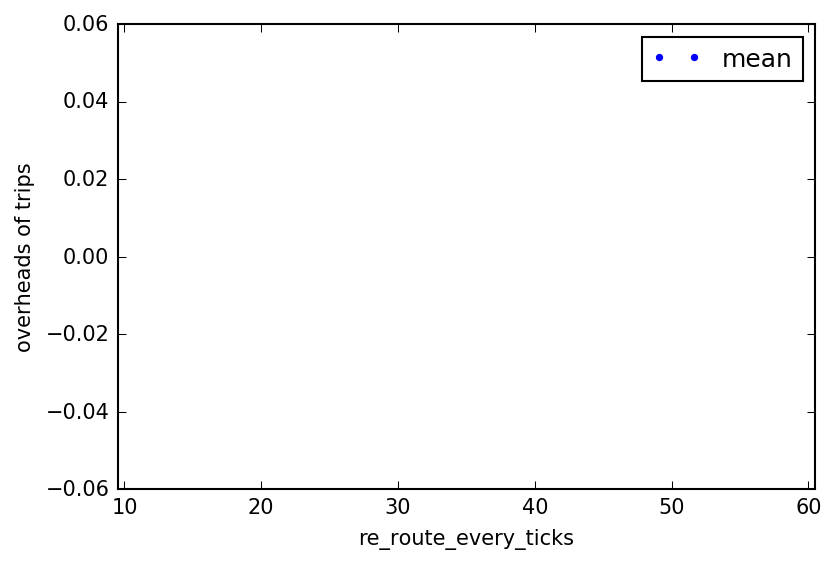

In [14]:
import matplotlib.pyplot as plt
from numpy import var, std, mean, median
import matplotlib as mpl
mpl.rc("savefig", dpi=150)

y_key = 'overhead'
sample_size = 10000

def getWidth(keys):
    highest_key = max(keys)
    if highest_key < 1:
        return 0.1
    if 1 <= highest_key < 10:
        return 0.2
    if 10 <= highest_key < 50:
        return 1
    if 50 <= highest_key < 100:
        return 4
    if 100 <= highest_key < 1000:
        return 30
    
for j in range(7): 
    knob_name = knob_names[j]
    keys = knob_values[j] 
    means = []
    all_data = []

    for i in keys:
        analysis_data = [r[y_key] for r in data[i]][:sample_size]
        all_data.append(analysis_data)
        means.append(mean(analysis_data))

    fig,ax = plt.subplots()
    ax.plot(keys,means, ".", label='mean')
    width = getWidth(keys)
    ax.boxplot(all_data, 0, '', positions=keys, widths=[width for k in keys])
#     ax.boxplot(all_data, 0, '', positions=keys)
    plt.xticks(keys, [str(k) for k in keys])
    plt.legend(loc='best')
    plt.ylabel('overheads of trips')
    plt.xlabel(knob_name)
    plt.show()

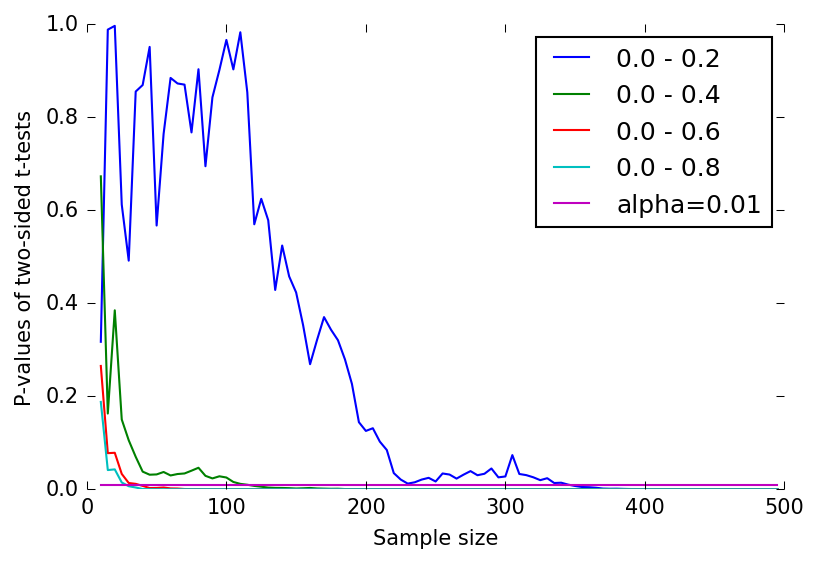

In [4]:
mpl.rc("savefig", dpi=150)

alpha = 0.01

fake_run_id = "123456"
comparison_keys = keys[1:]

sample_sizes = []
pvalues = {}

for i in keys:
    pvalues[i] = []

for sample_size in range(10, 500, 5):
    sample_sizes.append(sample_size)
    
    analysis_data = {}
    analysis_data[0] = data[0][:sample_size]
    
    for i in comparison_keys:   
        analysis_data[1] = data[i][:sample_size]
        t = Ttest(fake_run_id, y_key, alpha).start(analysis_data, {})
        pvalues[i].append(t["pvalue"])

markers = ['1','2','3','4','s','p','*','h','H']
marker_index = 0

fig,ax = plt.subplots()
for i in comparison_keys:
    ax.plot(sample_sizes,pvalues[i],label='0.0 - 0.'+str(i))
    marker_index += 1
    
ax.plot(sample_sizes,[alpha]*len(sample_sizes), label='alpha='+str(alpha))
ax.set_frame_on(False)
#ax.set_clip_on(False)
#ax.get_xaxis().tick_bottom()
#ax.axes.get_xaxis().set_visible(False)
plt.xlabel('Sample size')
plt.ylabel('P-values of two-sided t-tests')
plt.legend()
plt.show()

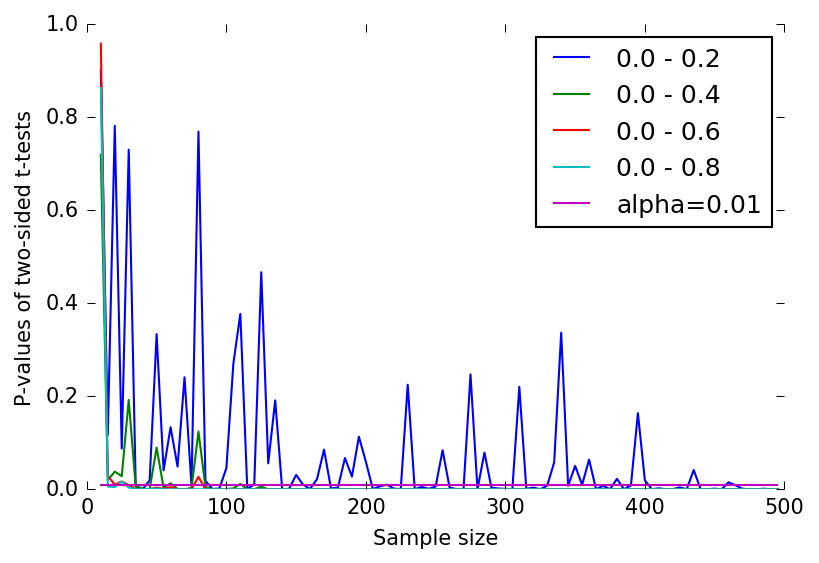

In [5]:
mpl.rc("savefig", dpi=150)
import random

alpha = 0.01

fake_run_id = "123456"
comparison_keys = keys[1:]

sample_sizes = []
pvalues = {}

for i in keys:
    pvalues[i] = []

for sample_size in range(10, 500, 5):
    sample_sizes.append(sample_size)
    
    analysis_data = {}
    analysis_data[0] = random.sample(data[0], sample_size)
    
    for i in comparison_keys:   
        analysis_data[1] = random.sample(data[i], sample_size)
        t = Ttest(fake_run_id, y_key, alpha).start(analysis_data, {})
        pvalues[i].append(t["pvalue"])

markers = ['1','2','3','4','s','p','*','h','H']
marker_index = 0

fig,ax = plt.subplots()
for i in comparison_keys:
    ax.plot(sample_sizes,pvalues[i],label='0.0 - 0.'+str(i))
    marker_index += 1
    
ax.plot(sample_sizes,[alpha]*len(sample_sizes), label='alpha='+str(alpha))
ax.set_frame_on(False)
plt.legend()
plt.xlabel('Sample size')
plt.ylabel('P-values of two-sided t-tests')
plt.show()

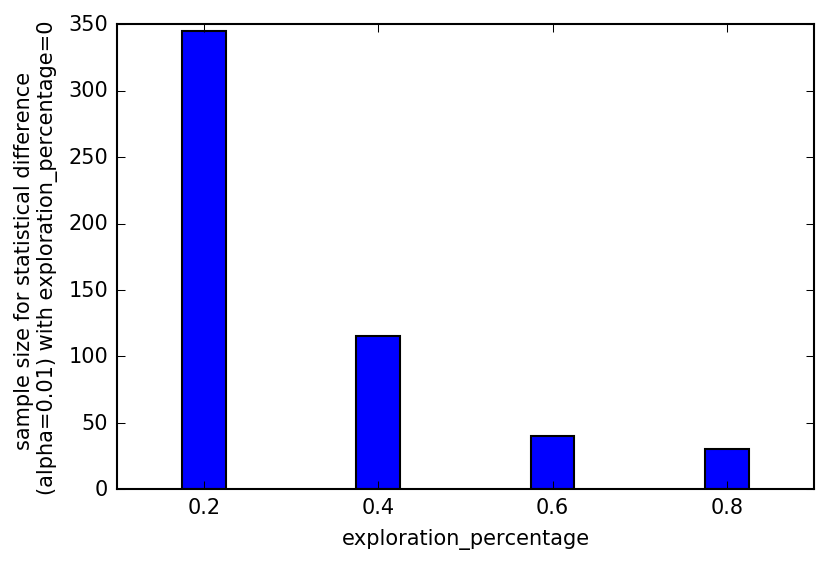

In [6]:
mpl.rc("savefig", dpi=150)
import collections

alpha = 0.01

fake_run_id = "123456"
comparison_keys = keys[1:]

necessary_samples_sizes = collections.OrderedDict()

for i in comparison_keys:   
    for sample_size in range(10, 500, 5):
    
        analysis_data = {}
        analysis_data[0] = data[0][:sample_size]
        analysis_data[1] = data[i][:sample_size]
#         analysis_data[0] = random.sample(data[0], sample_size)
#         analysis_data[1] = random.sample(data[i], sample_size)
        
        t = Ttest(fake_run_id, y_key, alpha).start(analysis_data, {})
        if t["pvalue"] <= alpha:
            necessary_samples_sizes[i] = sample_size
            break
    if not i in necessary_samples_sizes.keys():
        necessary_samples_sizes[i] = 500
        
bar_width = 0.05

plt.figure()
plt.bar([float("0."+str(k))-(bar_width/2) for k in necessary_samples_sizes.keys()], 
        necessary_samples_sizes.values(), bar_width)
plt.xlabel(knob)
plt.ylabel('sample size for statistical difference \n(alpha='+str(alpha)+') with ' + knob + '=0')
plt.xticks([float('0.'+str(k)) for k in necessary_samples_sizes.keys()])
plt.show()